# RFP: Maze Solvers

## Project Overview
You are invited to submit a proposal that answers the following question:

### What path will your elf take?

*Please submit your proposal by **2/11/25 at 11:59 PM**.*

## Required Proposal Components

### 1. Data Description
In the code cell below, use [Gymnasium](https://gymnasium.farama.org/) to set up a [Frozen Lake maze](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) for your project. When you are done with the set up, describe the reward system you plan on using.

*Note, a level 5 maze is at least 10 x 10 cells large and contains at least five lake cells.*

In [1]:
import gymnasium as gym
from gymnasium.envs.toy_text.frozen_lake import generate_random_map
import json

# Generate a random map (e.g. 10x10)
random_map = generate_random_map(size=10)

# Optionally, save the random map to a JSON file for later use
with open("random_map.json", "w") as f:
    json.dump(random_map, f)

# Create the FrozenLake environment using the generated random map
env = gym.make('FrozenLake-v1', desc=random_map, render_mode='rgb_array', is_slippery=False)

# Reset the environment (without a fixed seed for varied exploration) and render once
state_info, _ = env.reset()
env.render()
env.close()

print("Random map used:")
for row in random_map:
    print(row)


Random map used:
SFFFHHFHHF
FFFHFFFFFF
HFHFHFFFFF
FFFHFFFFFF
HHFFFFFFFF
FHFFFFFFHH
FHFFFFFFFF
FFFHFFFFFH
FFFFFFFFFF
FFHFFFFFHG


#### Describe your reward system here.

### 2. Training Your Model
In the cell seen below, write the code you need to train a Q-Learning model. Display your final Q-table once you are done training your model.

*Note, level 5 work uses only the standard Python library and Pandas to train your Q-Learning model. A level 4 uses external libraries like Baseline3.*

Episode 100: Total Env Reward = 0.0, Epsilon = 0.613
Episode 200: Total Env Reward = 0.0, Epsilon = 0.376
Episode 300: Total Env Reward = 0.0, Epsilon = 0.232
Episode 400: Total Env Reward = 0.0, Epsilon = 0.145
Episode 500: Total Env Reward = 0.0, Epsilon = 0.092
Episode 600: Total Env Reward = 0.0, Epsilon = 0.060
Episode 700: Total Env Reward = 0.0, Epsilon = 0.040
Episode 800: Total Env Reward = 0.0, Epsilon = 0.028
Episode 900: Total Env Reward = 0.0, Epsilon = 0.021
Episode 1000: Total Env Reward = 0.0, Epsilon = 0.017
Episode 1100: Total Env Reward = 0.0, Epsilon = 0.014
Episode 1200: Total Env Reward = 0.0, Epsilon = 0.012
Episode 1300: Total Env Reward = 0.0, Epsilon = 0.011
Episode 1400: Total Env Reward = 0.0, Epsilon = 0.011
Episode 1500: Total Env Reward = 0.0, Epsilon = 0.011
Episode 1600: Total Env Reward = 0.0, Epsilon = 0.010
Episode 1700: Total Env Reward = 0.0, Epsilon = 0.010
Episode 1800: Total Env Reward = 0.0, Epsilon = 0.010
Episode 1900: Total Env Reward = 0.0,

[[ 7.64274979e-01  7.96113016e-01  7.17477958e-01  7.70728952e-01]
 [ 1.75652997e-01  7.42324472e-01  1.26429268e-01  1.27959474e-01]
 [ 1.86179660e-02  1.02432067e-01  4.51328619e-02  5.41496920e-02]
 [-7.72338076e-03  2.49898133e-02  1.01333333e-02  3.61333333e-04]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.06021818e-01  5.44417233e-02  7.48599006e-01  6.88476774e-01]
 [ 6.38586176e-01  7.01166224e-01  1.06687941e-01  5.67894703e-01]
 [ 3.98030333e-02  5.33332418e-02  4.74976539e-02  2.81428799e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e

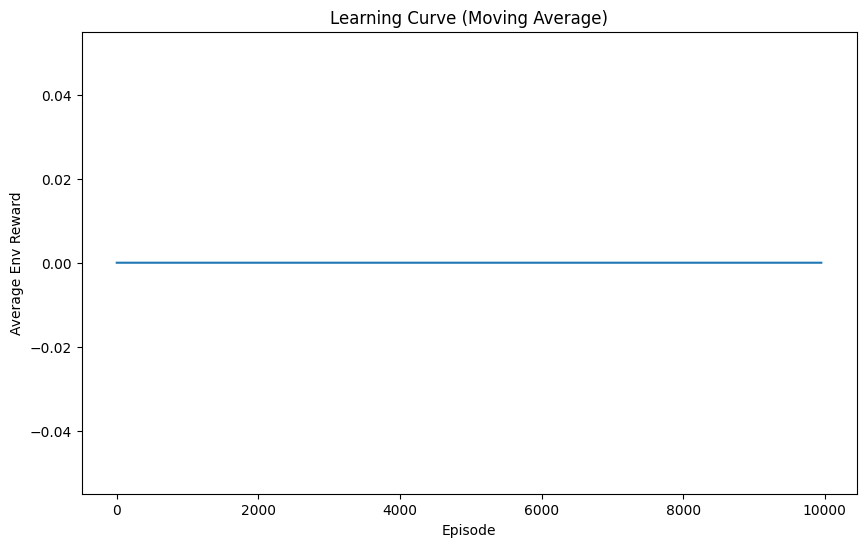

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
import json
import gymnasium as gym

logging.basicConfig(level=logging.INFO, format='%(message)s')

# --- Load the saved random map ---
with open("random_map.json", "r") as f:
    random_map = json.load(f)

# --- Utility Functions ---
def get_grid_dimensions(map_desc):
    """Return grid dimensions based on the map description (a list of strings)."""
    grid_height = len(map_desc)
    grid_width = len(map_desc[0])
    return grid_height, grid_width

def state_to_coords(state, grid_width):
    """Convert a state (integer) into (row, col) coordinates."""
    row = state // grid_width
    col = state % grid_width
    return row, col

# --- Potential-Based Reward Shaping ---
def potential_function(state, grid_width, grid_height, goal_state):
    """
    Compute the normalized potential based on Manhattan distance.
    Returns 1 at the goal and 0 at the farthest state.
    """
    row, col = state_to_coords(state, grid_width)
    goal_row, goal_col = state_to_coords(goal_state, grid_width)
    manhattan_distance = abs(row - goal_row) + abs(col - goal_col)
    max_distance = (grid_width - 1) + (grid_height - 1)
    return 1 - (manhattan_distance / max_distance)

# --- Training Function ---
def train_agent(num_episodes=100000000, max_steps=100000, alpha=0.1, gamma=0.99,
                epsilon=1.0, min_epsilon=0.01, decay_rate=0.005,
                max_time_bonus=10, finish_bonus=100, debug=False):
    """
    Trains a Q-learning agent with potential-based reward shaping.
    Uses the global 'env' and 'random_map' (loaded from file).
    """
    grid_height, grid_width = get_grid_dimensions(random_map)
    num_states = env.observation_space.n
    num_actions = env.action_space.n
    goal_state = num_states - 1  # assuming the goal is at the bottom-right
    
    q_table = np.zeros((num_states, num_actions))
    rewards_all_episodes = []
    
    for episode in range(num_episodes):
        state, _ = env.reset()  # no fixed seed for varied exploration
        if isinstance(state, (list, tuple, np.ndarray)):
            state = int(state[0])
        total_reward = 0
        
        for step in range(1, max_steps + 1):
            # Epsilon-greedy action selection
            if np.random.random() < epsilon:
                action = np.random.randint(num_actions)
            else:
                action = np.argmax(q_table[state, :])
            
            new_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            if isinstance(new_state, (list, tuple, np.ndarray)):
                new_state = int(new_state[0])
            
            # Compute potential-based shaping
            phi_state = potential_function(state, grid_width, grid_height, goal_state)
            phi_new_state = potential_function(new_state, grid_width, grid_height, goal_state)
            shaping = gamma * phi_new_state - phi_state
            
            # Time bonus based on remaining steps (higher bonus for faster solutions)
            time_bonus = max(0, max_time_bonus - step)
            
            # Compute shaped reward
            shaped_reward = reward + shaping
            if done:
                if reward == 1.0:  # Goal reached
                    shaped_reward += finish_bonus + time_bonus  # Success bonus + time bonus
                else:  # Falls in lake or fails
                    shaped_reward = reward + shaping  # No time bonus for failure
            
            # Q-learning update
            q_table[state, action] += alpha * (
                shaped_reward + gamma * np.max(q_table[new_state, :]) - q_table[state, action])
            
            state = new_state
            total_reward += reward
            
            if debug:
                logging.debug(f"Episode {episode+1}, Step {step}: State={state}, Action={action}, "
                              f"Env Reward={reward:.2f}, Shaping={shaping:.2f}, Time Bonus={time_bonus:.2f}, "
                              f"Shaped Reward={shaped_reward:.2f}, Done={done}")
            if done:
                break
        
        rewards_all_episodes.append(total_reward)
        # Update epsilon with exponential decay
        epsilon = min_epsilon + (1.0 - min_epsilon) * np.exp(-decay_rate * episode)
        if (episode + 1) % 100 == 0:
            logging.info(f"Episode {episode+1}: Total Env Reward = {total_reward}, Epsilon = {epsilon:.3f}")
    
    return q_table, rewards_all_episodes

def moving_average(data, window=50):
    """Compute the moving average over a given window."""
    return np.convolve(data, np.ones(window)/window, mode='valid')

def plot_learning_curve(rewards, window=50):
    """Plot the moving average of rewards over episodes."""
    avg_rewards = moving_average(rewards, window)
    plt.figure(figsize=(10, 6))
    plt.plot(avg_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Average Env Reward")
    plt.title("Learning Curve (Moving Average)")
    plt.show()

# Create the environment using the loaded random map
env = gym.make('FrozenLake-v1', desc=random_map, render_mode='rgb_array', is_slippery=False)

# Train the agent
q_table, rewards = train_agent(num_episodes=10000, max_steps=1000, alpha=0.1, gamma=0.99,
                               epsilon=1.0, min_epsilon=0.01, decay_rate=0.005,
                               max_time_bonus=10, finish_bonus=100, debug=False)

logging.info("Final Q-table:")
print(q_table)
plot_learning_curve(rewards, window=50)

# Save the trained Q-table for later use
np.save("q_table.npy", q_table)


### 3. Testing Your Model
In the cell seen below, write the code you need to test your Q-Learning model for **1000 episodes**. It is important to test your model for 1000 episodes so that we are all able to compare our results.

*Note, level 5 testing uses both a success rate and an average steps taken metric to evaluate your model. Level 4 uses one or the other.*

In [3]:
import gymnasium as gym
import numpy as np
import json

# Load the random map (to ensure consistency)
with open("random_map.json", "r") as f:
    random_map = json.load(f)

# Create the environment with the same random map
env = gym.make('FrozenLake-v1', desc=random_map, render_mode='rgb_array', is_slippery=False)

# Load the trained Q-table
q_table = np.load("q_table.npy")

goal_state = env.observation_space.n - 1
num_test_episodes = 1000

for episode in range(num_test_episodes):
    state, _ = env.reset()  # no fixed seed for variation
    if isinstance(state, (list, tuple, np.ndarray)):
        state = int(state[0])
    done = False
    total_episode_reward = 0
    steps = 0

    while not done:
        action = np.argmax(q_table[state, :])
        new_state, reward, terminated, truncated, _ = env.step(action)
        if isinstance(new_state, (list, tuple, np.ndarray)):
            new_state = int(new_state[0])
        state = new_state
        total_episode_reward += reward
        steps += 1
        done = terminated or truncated

        if state == goal_state:
            print(f"Episode {episode + 1}: Agent reached goal in {steps} steps!")
            break

    print(f"Episode {episode + 1} completed in {steps} steps with reward {total_episode_reward}")

env.close()


Episode 1 completed in 17 steps with reward 0.0
Episode 2 completed in 17 steps with reward 0.0
Episode 3 completed in 17 steps with reward 0.0
Episode 4 completed in 17 steps with reward 0.0
Episode 5 completed in 17 steps with reward 0.0
Episode 6 completed in 17 steps with reward 0.0
Episode 7 completed in 17 steps with reward 0.0
Episode 8 completed in 17 steps with reward 0.0
Episode 9 completed in 17 steps with reward 0.0
Episode 10 completed in 17 steps with reward 0.0
Episode 11 completed in 17 steps with reward 0.0
Episode 12 completed in 17 steps with reward 0.0
Episode 13 completed in 17 steps with reward 0.0
Episode 14 completed in 17 steps with reward 0.0
Episode 15 completed in 17 steps with reward 0.0
Episode 16 completed in 17 steps with reward 0.0
Episode 17 completed in 17 steps with reward 0.0
Episode 18 completed in 17 steps with reward 0.0
Episode 19 completed in 17 steps with reward 0.0
Episode 20 completed in 17 steps with reward 0.0
Episode 21 completed in 17 st

Episode 683 completed in 17 steps with reward 0.0
Episode 684 completed in 17 steps with reward 0.0
Episode 685 completed in 17 steps with reward 0.0
Episode 686 completed in 17 steps with reward 0.0
Episode 687 completed in 17 steps with reward 0.0
Episode 688 completed in 17 steps with reward 0.0
Episode 689 completed in 17 steps with reward 0.0
Episode 690 completed in 17 steps with reward 0.0
Episode 691 completed in 17 steps with reward 0.0
Episode 692 completed in 17 steps with reward 0.0
Episode 693 completed in 17 steps with reward 0.0
Episode 694 completed in 17 steps with reward 0.0
Episode 695 completed in 17 steps with reward 0.0
Episode 696 completed in 17 steps with reward 0.0
Episode 697 completed in 17 steps with reward 0.0
Episode 698 completed in 17 steps with reward 0.0
Episode 699 completed in 17 steps with reward 0.0
Episode 700 completed in 17 steps with reward 0.0
Episode 701 completed in 17 steps with reward 0.0
Episode 702 completed in 17 steps with reward 0.0


### 4. Final Answer
In the first cell below, describe the path your elf takes to get to the gift. *Note, a level 5 answer includes a gif of the path your elf takes in order to reach the gift.*

In the second cell seen below, describe how well your Q-Learning model performed. Make sure that you explicitly name the **learning rate**, **the discount factor**, and the **reward system** that you used when training your final model. *Note, a level 5 description describes the model's performance using two types of quantitative evidence.*

![example image](https://gymnasium.farama.org/_images/frozen_lake.gif)

#### Describe the path your elf takes here.

#### Describe how well your Q-Learning model performed here.


In [4]:
import gymnasium as gym
import numpy as np
import imageio
import os
import shutil
import json

# Load the random map
with open("random_map.json", "r") as f:
    random_map = json.load(f)

# Create the environment with the same random map
env = gym.make('FrozenLake-v1', desc=random_map, render_mode='rgb_array', is_slippery=False)
q_table = np.load("q_table.npy")

video_dir = "frozen_lake_path"

# Remove existing folder if present, then create a new one
if os.path.exists(video_dir):
    shutil.rmtree(video_dir, ignore_errors=True)
os.makedirs(video_dir, exist_ok=True)

frames = []  # List to store frames
state_info, _ = env.reset()  # reset environment (varied start)
if isinstance(state_info, (list, tuple, np.ndarray)):
    state = int(state_info[0])
else:
    state = state_info
done = False

# Capture frames as the agent follows the learned policy
while not done:
    frame = env.render()  # Capture current frame
    frames.append(frame)
    action = np.argmax(q_table[state, :])
    new_state, reward, terminated, truncated, _ = env.step(action)
    if isinstance(new_state, (list, tuple, np.ndarray)):
        new_state = int(new_state[0])
    state = new_state
    done = terminated or truncated

# Save the frames as a GIF
gif_path = os.path.join(video_dir, "frozen_lake_path.gif")
imageio.mimsave(gif_path, frames, duration=0.5)

print(f"GIF saved at: {gif_path}")
env.close()


GIF saved at: frozen_lake_path\frozen_lake_path.gif


In [5]:
env.close()